# Problema

Predecir el coste del seguro

## Instrucciones

 Utilizar el dataset (insurance.csv) para entrenar un modelo de regresión capaz de predecir el valor del seguro en función de las características del cliente. Realizar limpieza, preprocesado modelado y testeo del modelo aportando conclusiones de todos estos pasos.

# El set de datos

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

In [2]:
ruta = "insurance.csv"
data = pd.read_csv(ruta)

In [3]:
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Objetivo

Generar un model de regresión capaz de predecir el valor del seguro en base a las características del cliente.

* Aplicar las técnicas oportunas de procesamiento de datos (lipieza, nans, escalado...)

* Valorar diferentes modelos de regresión (linear regressor, polynomial, ridge, lasso, elastic, decission tree y random forest)

* Comparación entre modelos (dividir el dataset en train y test, entrenar con el train y evaluar con el test)

* Métricas (todas, y que aporta cada una)

* Conclusiones finales

# EDA + PREPROCESADO

## Implementación

In [4]:
#Saco el tipo de datos de cada característica

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
nans_por_columna = data.isna().sum()

print(nans_por_columna)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No se presentan NAN en el dataset

In [6]:
missing_values= data.isnull().sum()

print(missing_values)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No se presentan valores nulos en el dataset

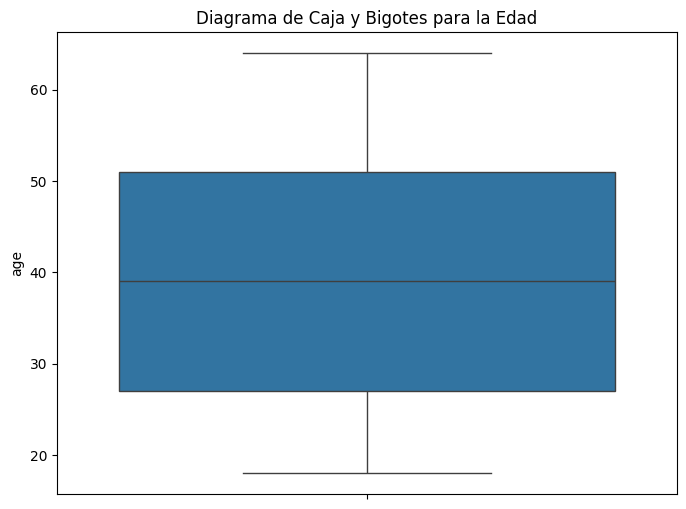

In [7]:
 #Diagrama de cajas para la edad

plt.figure(figsize=(8, 6))
sns.boxplot(data=data['age'])

plt.title("Diagrama de Caja y Bigotes para la Edad")
plt.show()

La edad no presenta valores atípicos se distribuyen de forma normal.

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

En la característica 'sex' lo valores solo son 'female' o 'male'.

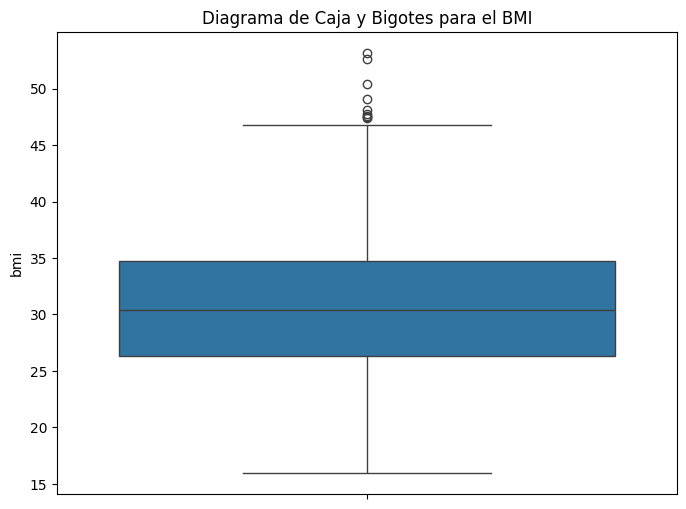

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data['bmi'])

plt.title("Diagrama de Caja y Bigotes para el BMI")
plt.show()

In [11]:
print(data['bmi'].max())
print(data['bmi'].min())

53.13
15.96


Se detecta una población con tendencia al sobrepeso. Los outliers superiores a 47 detectados, tras investigar no decimos clipear estos outliers porque si existen personas con un BMI superior a estos valores. Se clasificarían como personas con obesidad extrema con necesidad de intervención quirúrgica y o tratamiento urgente.

In [12]:
data['children'].unique()

array([0, 1, 3, 2, 5, 4])

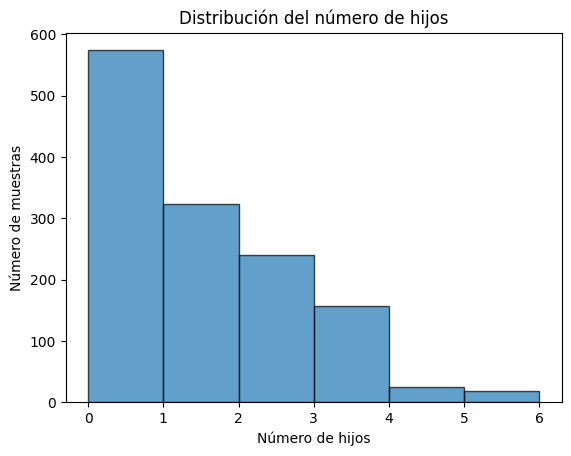

In [13]:
plt.hist(data['children'], bins=range(0, max(data['children']) + 2), edgecolor='black', alpha=0.7)

# Agregar títulos y etiquetas
plt.title('Distribución del número de hijos')
plt.xlabel('Número de hijos')
plt.ylabel('Número de muestras')

# Mostrar el gráfico
plt.show()

Como es habitual la mayor parte de la población está situada de 0 a 3.

In [14]:
data['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [15]:
data['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

Valores correctos para la característica 'smoker' como descrito en el dataset

In [16]:
data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Valores correctos para la característica 'region' como está descrito en el dataset

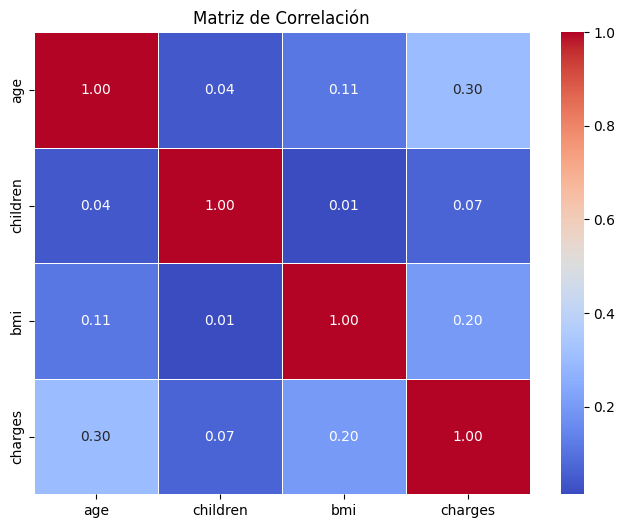

In [17]:
num = ['age','children','bmi','charges']
data_num = data[num]

# Calcular la matriz de correlación
correlation_matrix = data_num.corr()

# Crear el gráfico de correlación (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Mostrar el gráfico
plt.title('Matriz de Correlación')
plt.show()

La edad es la que presenta una mayor correlación respecto a la variable a predecir ('charges') pero es bastante bajo tan solo un 30%.

PROCEDEMOS A TRANSFORMAR LAS CATEGÓRICAS

In [18]:
le = LabelEncoder()

data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['region'] = le.fit_transform(data['region'])

print(data)

      age  sex     bmi  children  smoker  region      charges
0      19    0  27.900         0       1       3  16884.92400
1      18    1  33.770         1       0       2   1725.55230
2      28    1  33.000         3       0       2   4449.46200
3      33    1  22.705         0       0       1  21984.47061
4      32    1  28.880         0       0       1   3866.85520
...   ...  ...     ...       ...     ...     ...          ...
1333   50    1  30.970         3       0       1  10600.54830
1334   18    0  31.920         0       0       0   2205.98080
1335   18    0  36.850         0       0       2   1629.83350
1336   21    0  25.800         0       0       3   2007.94500
1337   61    0  29.070         0       1       1  29141.36030

[1338 rows x 7 columns]


PROCEDEMOS A ESCALAR LAS VARIABLES NÚMERICAS

In [19]:
scaler = StandardScaler()
data[['age','bmi','children']] = scaler.fit_transform(data[['age','bmi','children']])

print(data)

           age  sex       bmi  children  smoker  region      charges
0    -1.438764    0 -0.453320 -0.908614       1       3  16884.92400
1    -1.509965    1  0.509621 -0.078767       0       2   1725.55230
2    -0.797954    1  0.383307  1.580926       0       2   4449.46200
3    -0.441948    1 -1.305531 -0.908614       0       1  21984.47061
4    -0.513149    1 -0.292556 -0.908614       0       1   3866.85520
...        ...  ...       ...       ...     ...     ...          ...
1333  0.768473    1  0.050297  1.580926       0       1  10600.54830
1334 -1.509965    0  0.206139 -0.908614       0       0   2205.98080
1335 -1.509965    0  1.014878 -0.908614       0       2   1629.83350
1336 -1.296362    0 -0.797813 -0.908614       0       3   2007.94500
1337  1.551686    0 -0.261388 -0.908614       1       1  29141.36030

[1338 rows x 7 columns]


# MODELADO

In [20]:
train, val = train_test_split(data, test_size=0.3, random_state=42,stratify=data['smoker'])  # 70% entrenamiento y 30% validación

Hacemos stratify de los fumadores ya que es algo que afecta directamente a la salud y las muestras entre fumadores y no fumadores están bastante desbalanceadas. Así tendremos la misma proporción en ambos splits.

In [21]:
print(train.shape[0])
print(val.shape[0])

936
402


Comprobamos que el stratify es correcto

In [22]:
print(train['smoker'].value_counts())
print(val['smoker'].value_counts())

smoker
0    744
1    192
Name: count, dtype: int64
smoker
0    320
1     82
Name: count, dtype: int64


In [23]:
train_nc = train.drop('charges',axis = 1)
y_train = train['charges']

In [24]:
val_nc = val.drop('charges',axis = 1)
y_val = val['charges']

In [26]:
print(val_nc)
print(y_val)

           age  sex       bmi  children  smoker  region
1279 -1.011557    0 -0.635409  0.751079       0       1
1002 -1.082758    1 -0.797813 -0.908614       0       3
17   -1.153959    1 -1.118520 -0.908614       0       0
192  -1.011557    1 -0.807656 -0.908614       0       2
610   0.554869    0 -0.212175 -0.078767       0       2
...        ...  ...       ...       ...     ...     ...
1085 -0.014740    0 -2.028147  3.240619       1       3
804  -1.153959    1 -0.681342 -0.908614       0       2
1081 -0.513149    1 -0.463983 -0.078767       0       1
917   0.412467    1 -1.274363 -0.908614       1       0
863  -0.228344    0 -1.773058 -0.908614       0       0

[402 rows x 6 columns]
1279     4189.11310
1002     1972.95000
17       2395.17155
192      2137.65360
610      8547.69130
           ...     
1085    19023.26000
804      1815.87590
1081     4454.40265
917     35069.37452
863      5458.04645
Name: charges, Length: 402, dtype: float64


In [543]:
linear_model = LinearRegression()
linear_model.fit(train_nc, y_train)

LinearRegression()

In [544]:
y_pred_l = linear_model.predict(val_nc)

linear_mse = mean_squared_error(y_val, y_pred_l)
linear_mae = mean_absolute_error(y_val,y_pred_l)
linear_mape = mean_absolute_percentage_error(y_val,y_pred_l)

# Imprimir el MSE
print("Mean Squared Error: ", linear_mse)
print("Mean Absolute Error: ", linear_mae)
print("Mean Aboslite Percentage Error: ", linear_mape)


Mean Squared Error:  33680194.69255102
Mean Absolute Error:  3993.596721116636
Mean Aboslite Percentage Error:  0.39521139057419075


In [545]:
decision_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
decision_tree.fit(train_nc, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [546]:
y_pred_dt = decision_tree.predict(val_nc)

dt_mse = mean_squared_error(y_val, y_pred_dt)
dt_mae = mean_absolute_error(y_val,y_pred_dt)
dt_mape = mean_absolute_percentage_error(y_val,y_pred_dt)

# Imprimir el MSE
print("Mean Squared Error: ", dt_mse)
print("Mean Absolute Error: ",dt_mae)
print("Mean Aboslite Percentage Error: ", dt_mape)

Mean Squared Error:  22545587.220277254
Mean Absolute Error:  2767.848262772227
Mean Aboslite Percentage Error:  0.3437184184069996


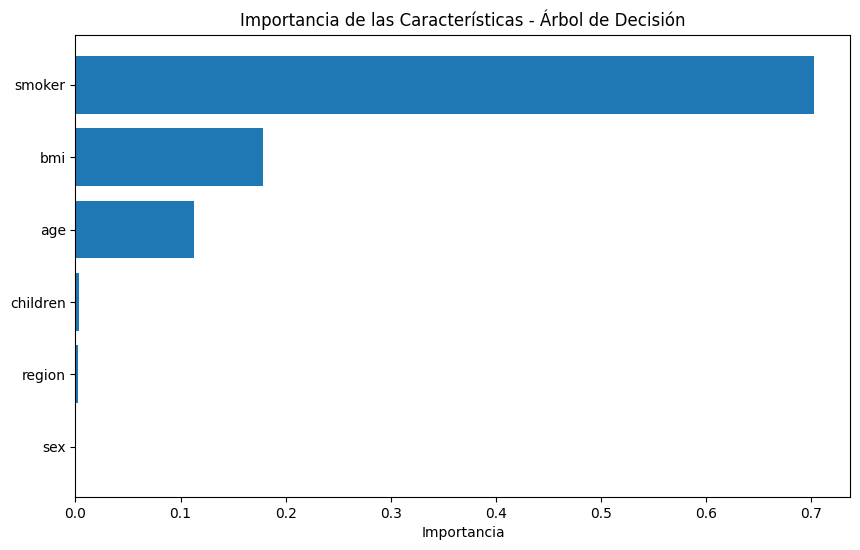

In [547]:
importancia = decision_tree.feature_importances_

# Visualizar las importancias
indices = np.argsort(importancia)  # Ordena las importancias de menor a mayor

plt.figure(figsize=(10, 6))
plt.title("Importancia de las Características - Árbol de Decisión")
plt.barh(range(train_nc.shape[1]), importancia[indices], align="center")
plt.yticks(range(train_nc.shape[1]), [train_nc.columns[i] for i in indices])
plt.xlabel("Importancia")
plt.show()

In [27]:
random_forest = RandomForestRegressor(
    n_estimators=100,      
    max_depth=10,           
    min_samples_split=10,           
    random_state=42,                     
)

random_forest.fit(train_nc, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

In [28]:
y_pred_rf = random_forest.predict(val_nc)

rf_mse = mean_squared_error(y_val, y_pred_rf)
rf_mae = mean_absolute_error(y_val,y_pred_rf)
rf_mape = mean_absolute_percentage_error(y_val,y_pred_rf)

# Imprimir el MSE
print("Mean Squared Error: ", rf_mse)
print("Mean Absolute Error: ",rf_mae)
print("Mean Aboslite Percentage Error: ", rf_mape)

Mean Squared Error:  21802772.54419932
Mean Absolute Error:  2731.1220079606987
Mean Aboslite Percentage Error:  0.3419503089076997


HEMOS OBTENIDO LOS MEJORES RESULTADOS EN UN RANDOM FOREST Y EN UN ARBOL DE DECISION VAMOS A HACER UN GRIDSEARCH PARA COMPARAR AMBOS MODELOS CON ALGUNOS HIPERPARÁMETROS PARA VER SI CONSEGUIMOS MEJORAR LOS RESULTADOS

In [550]:
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2,5]
}

# GridSearchCV para Decision Tree
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, n_jobs=-1)
grid_search_dt.fit(train_nc, y_train)

# GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(train_nc, y_train)

y_pred_dt = grid_search_dt.predict(val_nc)
y_pred_rf = grid_search_rf.predict(val_nc)

mae_dt = mean_absolute_error(y_val, y_pred_dt)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
mape_dt = mean_absolute_percentage_error(y_val, y_pred_dt)
mape_rf = mean_absolute_percentage_error(y_val, y_pred_rf)

print(f"Decision Tree MAE: {mae_dt}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Decision Tree MAPE {mape_dt}")
print(f"Random Forest MAPE: {mape_rf}")

Decision Tree MAE: 2767.848262772227
Random Forest MAE: 2579.3905433648683
Decision Tree MAPE 0.3437184184069996
Random Forest MAPE: 0.31428191827813634


IMPRIMIMOS LOS MEJORES PARÁMETROS DEL RANDO FORESTS

In [551]:
print("Best parameters found: ", grid_search_rf.best_params_)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


# Conclusiones

El modelo que mejor métricas nos ha dado es el Random Forest con los hiperparámetros de:

    Max_depth: 10

    Min_samples_split: 2

    Min_samples_leaf: 5
    
    N_estimators: 200

Como hemos visto anteriormente en el gráfico de correlación las variables no están muy correladas entre sí, ni con la característica a predecir. Por tanto, podemos concluir que aplicando un modelo de regresión lineal múltiple íbamos a obtener peores resultados respecto a otros modelo como Decision Tree o Random Forest. Ya que estos modelos son capaces de capturar relaciones no lineales.

Se observa que el Decision Tree le da mucha importancia a la característica si es fumador o no para predecir. Además de que el % de fumadores es un 25% y estamos separando el dataset en 70% train - 30% val/test se podría dar el caso de que en train se queden muy pocos datos o incluso ninguno. Creo que aplicar un stratify en la división de splits sobre esta característica ha sido de gran ayuda.

Las métricas utilizadas para evaluar los modelos han sido:

 MSE: Promedio de los errores al cuadrado entre las predicciones y los valores reales.

 MAE: Promedio de los errores absolutos entre las predicciones y los valores reales.

 MAPE: Promedio de los errores absolutos en términos de porcentaje entre las predicciones y los valores reales.

 Para todas ellas el objetivo es minimizarlas ya que todas basan sus cálculos en los errores.